`Rasmus Utz Faber`

`Martín Omil Nogales`

# Unit 3 - Part 1: Custom CNNs

The CIFAR-100 dataset is a collection of 60,000 color images across 100 different classes, with each class containing 600 images. The dataset is divided into 50,000 training images and 10,000 test images, with each image having a resolution of 32x32 pixels. It is a challenging dataset due to its diverse categories and small image size.

In this notebook, we will analyze and compare the performance of five different deep learning models for classifying CIFAR-100:

1. **Base CNN Model** – A simple convolutional neural network used as a baseline.
2. **Optimized CNN Model** – The base CNN with hyperparameter tuning for improved performance.
3. **Residual Network (ResNet)** – A deep network with residual connections to combat vanishing gradients.
4. **Inception Network** – A model utilizing inception modules to capture multi-scale features.
5. **Xception Network** – An advanced architecture using depthwise separable convolutions for efficient learning.

We will implement and evaluate each of these models, comparing their accuracy and loss metrics.


## 3.1. Data Preprocessing

### 3.1.1 Dataset Download and Preprocessing

In this section, we handle the downloading, extraction, and preprocessing of the CIFAR-100 dataset. If the dataset is not already present, it is downloaded from the official website and stored locally. Once downloaded, the compressed archive is extracted, and the original archive file is removed to save space.

To load the dataset, we define a helper function (`unpickle`) that reads the data files and converts byte-encoded keys into standard Python strings for easier processing. Using this function, we load the training data, test data, and metadata, which includes the names of the 100 fine-grained labels and 20 coarse-grained label categories.

As part of the preprocessing step, the image data, which is originally stored as flat arrays, is reshaped into the format `(N, 32, 32, 3)`, where `N` is the number of images, `32x32` represents the image dimensions, and `3` corresponds to the RGB color channels. This reshaping ensures that the data is structured correctly for input into deep learning models. Additionally, the dataset's fine and coarse labels are extracted into separate arrays for later use.

At the end of this step, we have the training images (`images`), their corresponding fine and coarse labels, as well as the test set (`X_test`, `y_test`), all prepared for model training and evaluation.


In [1]:
import pickle
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import urllib.request
import tarfile
import os

# URL for CIFAR-100 dataset
data_url = "https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz"
data_dir = "cifar-100-python/"
archive_path = "cifar-100-python.tar.gz"

# Download dataset if not already present
if not os.path.exists(data_dir):
    print("Downloading CIFAR-100 dataset...")
    urllib.request.urlretrieve(data_url, archive_path)
    
    # Extract dataset
    print("Extracting dataset...")
    with tarfile.open(archive_path, "r:gz") as tar:
        tar.extractall()
    
    # Remove archive file after extraction
    os.remove(archive_path)

# Function to unpickle the CIFAR-100 dataset
def unpickle(file):
    with open(file, 'rb') as fo:
        data_dict = pickle.load(fo, encoding='bytes')
    return {k.decode('utf-8'): v for k, v in data_dict.items()}  # Convert keys to strings

# Load training and meta data
meta_data = unpickle(os.path.join(data_dir, "meta")) 
data_batch = unpickle(os.path.join(data_dir, "train")) 
test_batch = unpickle(os.path.join(data_dir, "test"))

# Get label names
fine_label_names = [name.decode('utf-8') for name in meta_data['fine_label_names']]
coarse_label_names = [name.decode('utf-8') for name in meta_data['coarse_label_names']]

# Extract images & labels
images = data_batch['data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)  # Convert to (N, 32, 32, 3)
fine_labels = np.array(data_batch['fine_labels'])
coarse_labels = np.array(data_batch['coarse_labels'])

X_test = test_batch['data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)  # Convert to (N, 32, 32, 3)
y_test = np.array(test_batch['fine_labels'])


2025-03-06 15:16:10.209271: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-06 15:16:10.226463: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741270570.243918 2854282 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741270570.249224 2854282 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-06 15:16:10.267012: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Extracting dataset...


To normalize the pixel values of the images to the range of 0 to 1, they get divided by 255. This normalization step helps to improve the model stability during training.

In [2]:
# Normalize images to range [0,1]
images = images.astype("float32") / 255.0
X_test = X_test.astype("float32") / 255.0

The fine-grained labels are converted into one-hot encoded vectors using to_categorical, which transforms class indices into binary matrices. This format is required for training deep learning models, particular when using categorical cross-entropy as a loss function. By representing labels in this way, the model can effectively handle multi-class classification, which is the core requirement of our use case.

In [3]:
from tensorflow.keras.utils import to_categorical

num_classes = 100  # CIFAR-100 has 100 fine-grained classes

# Convert labels to one-hot encoding
fine_labels_onehot = to_categorical(fine_labels, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

### 3.1.2 Creating the validation dataset

In order to achieve the best results for the model, it was decided to split the training dataset into a training dataset and a validation dataset, which makes up 20 % of the data from the set. That step leads to a total of 40000 training samples, 10000 validation samples and 10000 test samples. The validation dataset will be used for hyperparameter tuning for the custom created CNN.

In [4]:
# Split dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    images, fine_labels_onehot, test_size=0.2, random_state=42, stratify=fine_labels
)

print(f"Training samples: {X_train.shape[0]}, Validation samples: {X_val.shape[0]}, Test samples: {X_test.shape[0]}")


Training samples: 40000, Validation samples: 10000, Test samples: 10000


To ensure that the preprocessing steps were successfully applied, the first ten sample images from the preprocessed dataset along with their corresponding labels get visualied. This allows to confirm that the images are correctly reshaped, normalized, and labeled. By displaying these samples, we can also gain an initial understanding of the dataset's diversity and verify that the labels align correctly with the images.

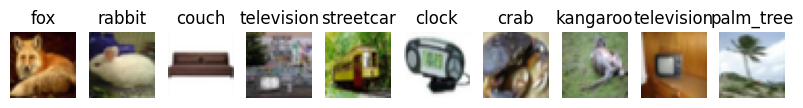

In [5]:
def plot_images(images, labels, fine_label_names, num=5):
    """Plot sample images with their labels."""
    plt.figure(figsize=(10, 2))
    for i in range(num):
        plt.subplot(1, num, i + 1)
        plt.imshow(images[i])
        label_idx = np.argmax(labels[i])  # Get the class index
        plt.title(fine_label_names[label_idx])
        plt.axis("off")
    plt.show()

plot_images(X_train, y_train, fine_label_names, num=10)



## 3.2 Developing a Custom Model for CIFAR-100 Classification

In this section, we will design and implement a custom convolutional neural network (CNN) from scratch to classify the CIFAR-100 dataset. Rather than using pretrained models or architectures from external libraries, we will carefully construct our model by determining the most effective combination of convolutional layers, pooling layers and other elements.

To achieve optimal performance, we will experiment with different architectures and hyperparameters. The validation dataset will be used to fine-tune hyperparameters and prevent overfitting. We will apply regularization techniques such as dropout, weight regularization, and data augmentation to improve generalization where necessary.

In addition to building a standard CNN, we will explore deeper and more complex architectures, including Residual Networks (ResNet), Inception Networks, and Xception Networks.

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt


To enhance the generalization capability of our model and reduce overfitting, we will apply data augmentation to the training dataset, artificially increasing the diversity of the training data by applying random transformations, helping the model learn more robust features. These modified images will be used to fine-tune the hyperparameters for the base CNN model.

In this case, we use the `ImageDataGenerator` class to perform several augmentations:
- **Rotation (`rotation_range=15`)**: Randomly rotates images by up to 15 degrees, making the model more robust to orientation changes.
- **Width and Height Shifts (`width_shift_range=0.1`, `height_shift_range=0.1`)**: Shifts images horizontally or vertically by up to 10% of their size, helping the model adapt to slight positional variations.
- **Horizontal Flipping (`horizontal_flip=True`)**: Randomly flips images along the horizontal axis, improving robustness to left-right asymmetry.

The augmented training set is then generated using `train_datagen.flow()`, which dynamically applies these transformations in real-time while feeding batches of size 64 into the model. This ensures that each training epoch sees slightly different variations of the same images, effectively improving the model’s ability to generalize to unseen data.

In [7]:
# Define data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
)

# Apply data augmentation to training set
train_generator = train_datagen.flow(X_train, y_train, batch_size=64)


### 3.2.1 Building the Base CNN Model

In this section, we define our baseline Convolutional Neural Network (CNN) classification task. This model serves as our starting point, providing a solid foundation for further optimizations and improvements.

The model follows a sequential structure, consisting of **three** convolutional blocks followed by a fully connected classification head. Each block contains a convolutional layer with ReLU activation, batch normalization to stabilize training, max pooling for downsampling, and dropout for regularization. The number of filters in the convolutional layers increases progressively, allowing the model to learn hierarchical features from the input images.

The fully connected layer at the end flattens the extracted features and passes them through a dense layer with 256 neurons, followed by another batch normalization and dropout layer. Finally, the output layer consists of 100 neurons with a softmax activation function, corresponding to the 100 classes in CIFAR-100.

In order to explore more hyperparameter configurations, this function will also take an optional `hp` argument in case we perform hyperparameter tuning using Keras Tuner. We aim to train two baseline CNN models:
- The first one, with default hyperparameter values.
- The second one, with the best hyperparameter configuration found by Keras Tuner.

The accuracy metric will be used to evaluate performance across all developed models.


In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam

def build_base_cnn(hp=None):
    model = Sequential()

    # Use default values if hp is None
    filters_1 = hp.Int('filters_1', 32, 64, step=16) if hp else 32
    dropout_1 = hp.Float('dropout_1', 0.2, 0.5, step=0.1) if hp else 0.3

    filters_2 = hp.Int('filters_2', 64, 128, step=32) if hp else 64
    dropout_2 = hp.Float('dropout_2', 0.2, 0.5, step=0.1) if hp else 0.3

    filters_3 = hp.Int('filters_3', 128, 256, step=64) if hp else 128
    dropout_3 = hp.Float('dropout_3', 0.3, 0.6, step=0.1) if hp else 0.4

    dropout_fc = hp.Float('dropout_fc', 0.3, 0.6, step=0.1) if hp else 0.4
    learning_rate = hp.Float('lr', 0.0001, 0.01, sampling='log') if hp else 0.001

    # First Block
    model.add(Conv2D(filters_1, (3,3), activation='relu', padding='same', input_shape=(32,32,3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(dropout_1))

    # Second Block
    model.add(Conv2D(filters_2, (3,3), activation='relu', padding='same')) 
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(dropout_2))

    # Third Block
    model.add(Conv2D(filters_3, (3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(dropout_3))

    # Fully Connected Layer
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_fc))
    model.add(Dense(100, activation='softmax'))

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


To optimize the performance of our base CNN model, instead of manually selecting values for parameters such as the number of filters, dropout rates, and learning rate, we automate the search for the best combination using a `RandomSearch` tuner made available by `Keras Tuner`.

The tuner is configured to search for the best model based on validation accuracy (`val_accuracy`), ensuring that the model generalizes well to unseen data. it will perform up to 7 trials (`max_trials=7`), where each trial trains a different combination of hyperparameters.


The tuning process is executed by calling `tuner.search()`, which trains multiple variations of the model using the augmented training data from before and evaluates them on the validation set over 25 epochs. Once the tuning process is complete, we can retrieve the best hyperparameters and use them to train our final optimized CNN model.

In [9]:
import keras_tuner as kt

tuner = kt.RandomSearch(
    build_base_cnn,
    objective='val_accuracy',
    max_trials=7,  
    directory='tuner_results',
    project_name='cifar100_base_cnn'
)

tuner.search(train_generator, validation_data=(X_val, y_val), epochs=25)


Trial 7 Complete [00h 08m 51s]
val_accuracy: 0.47450000047683716

Best val_accuracy So Far: 0.5001999735832214
Total elapsed time: 01h 02m 09s


### 3.2.2 Building a ResNet Model

Residual Networks (ResNets) are deep convolutional neural networks that incorporate **skip (residual) connections** to address the vanishing gradient problem and improve training efficiency. Instead of learning the full mapping from inputs to outputs, ResNet blocks learn residual functions, making it easier for the network to retain useful information across layers.

Our ResNet model consists of:
- **A standard convolutional layer** at the input to extract low-level features.
- **Multiple residual blocks**, where each block contains two convolutional layers with batch normalization. A residual connection adds the input of the block to its output before applying the ReLU activation. They are created using a helper function.
- **Downsampling using max pooling** after each residual block to reduce spatial dimensions.
- **Dropout layers** for regularization, preventing overfitting.
- **A fully connected classification head**, which flattens the extracted features and passes them through dense layers before making predictions using a softmax output.

During the creation of this network, we encountered some problems when getting the model to learn and generalize its knowledge on unseen data. The main problem was that the model overfit on the training data, reaching accuracies of up to 90%, while the validation accuracy remained at the expected accuracy (between 40% and 50%). After quick research, it was found out that overfitting is common weakness of ResNet networks. This issue is commonly tackled using regularization techniques and model simplification, which was applied by:

1. Initially, the model had a fourth residual block, which increased its capacity to memorize the training data and thus caused overfitting. By reducing the number of blocks, we limited the model's complexity, preventing it from overfitting to the training set while still maintaining the benefits of residual learning.

2. Dropout is a widely used regularization technique that randomly disables a fraction of neurons during training, forcing the model to learn more generalizable features. In the first iteration of the model, dropout was not applied, leading to overfitting. Then, by setting the dropout rate to 0.4 after each block and also applying it in the fully connected layer, we reduced reliance on specific neurons and improved performance on unseen data.

3. A high learning rate can potentially lead to overfitting. Initially we applied a learning rate of 0.001, which caused the model to converge way too quickly and overfitting on the training data. By decreasing the learning rate to 0.001, we allowed the model to make smaller, more controlled updates to the weights, leading to a more stable and generalized learning process.



In [10]:
from tensorflow.keras.layers import Add, Input

def residual_block(x, filters):
    res = Conv2D(filters, (3,3), padding='same', activation='relu')(x)
    res = BatchNormalization()(res)
    res = Conv2D(filters, (3,3), padding='same')(res)
    res = BatchNormalization()(res)

    if x.shape[-1] != filters:
        x = Conv2D(filters, (1,1), padding='same')(x)
    
    x = Add()([x, res])  # Residual Connection
    return tf.keras.activations.relu(x)

def build_resnet():
    inputs = Input(shape=(32,32,3))
    x = Conv2D(64, (3,3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)

    x = residual_block(x, 64)
    x = MaxPooling2D((2,2))(x)
    x = Dropout(0.4)(x)

    x = residual_block(x, 128)
    x = MaxPooling2D((2,2))(x)
    x = Dropout(0.4)(x)
    
    x = residual_block(x, 256)
    x = MaxPooling2D((2,2))(x)
    x = Dropout(0.4)(x)  

    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(100, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


### 3.2.3 Building an Inception Model

The **Inception architecture** is designed to improve feature extraction by capturing multi-scale spatial patterns within an image. Instead of using a single kernel size per layer, an Inception block applies multiple convolutional filters of different sizes in parallel. This allows the model to learn both fine-grained and coarse-grained features simultaneously.

The key components of our own Inception model include:

- **Inception Blocks**: each block applies 1×1, 3×3, and 5×5 convolutions in parallel, along with **a 3×3 max pooling operation**. The outputs from these parallel paths are concatenated, allowing the model to learn rich hierarchical representations.
- **Batch Normalization**: applied after each block to stabilize training and speed up convergence.
- **Dropout Regularization**: used at various stages to prevent overfitting and encourage generalization.
- **L2 Regularization**: applied to convolutional layers to further reduce overfitting.
- **Fully Connected Layer**: the final dense layer maps the extracted features to the 100 classes using a softmax activation function.

During the development of this model, different issues were encountered. In its first iteration, the model showed no ability to learn from the data, as it showcased a constant training and validation accuracy of 0.01 across all epochs. This was tackled in different ways:
1. First, we added another convolution to the inception blocks. At first they only included 1x1 and 3x3 convolutions, which caused the model to not be able to learn properly. To fix this, we modified the inception block by adding an additional convolutional layer with a 5x5 kernel and applying it after the initial 1x1 convolution. This allowed the model to capture more diverse and complex features at multiple scales. We also introduced a 1x1 convolution after max pooling to help retain spatial information and prevent overfitting.
2. We applied L2 regularization with a coefficient of 1e-4 to the convolutional and output layers. This regularization technique helps penalize large weights, encouraging the model to learn simpler, more robust features. By doing so, the model becomes less prone to overfitting to the training data, ultimately improving its ability to generalize to unseen data during both training and validation.
3. It was also necessary in this case to reduce the learning rate, as in previous iterations of the model, it converged too quickly and caused overfitting.

In [11]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, concatenate, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

def inception_block(x, filters):
    conv1x1 = Conv2D(filters, (1,1), padding='same', activation='relu')(x)
    
    conv3x3 = Conv2D(filters, (3,3), padding='same', activation='relu')(conv1x1)
    
    conv5x5 = Conv2D(filters, (5,5), padding='same', activation='relu')(x)
    
    pooled = MaxPooling2D((3,3), strides=(1,1), padding='same')(x)
    pooled = Conv2D(filters, (1,1), padding='same', activation='relu', kernel_regularizer=l2(1e-4))(pooled)

    concat = concatenate([conv1x1, conv3x3, conv5x5, pooled], axis=-1)
    return BatchNormalization()(concat)

def build_inception():
    inputs = Input(shape=(32,32,3))
    x = Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(inputs)
    x = BatchNormalization()(x)
    
    x = inception_block(x, 64)
    x = MaxPooling2D((2,2))(x)
    x = Dropout(0.4)(x)

    x = inception_block(x, 128)
    x = MaxPooling2D((2,2))(x)
    x = Dropout(0.4)(x)

    x = inception_block(x, 256)
    x = MaxPooling2D((2,2))(x)
    x = Dropout(0.5)(x)

    x = Flatten()(x)  
    x = Dense(128, activation='relu')(x)  # Reduce FC layer size
    x = Dropout(0.5)(x)
    outputs = Dense(100, activation='softmax', kernel_regularizer=l2(1e-4))(x)
    
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


### 3.2.4 Building an Xception Model

The **Xception (Extreme Inception)** model is an advanced deep learning architecture that extends the Inception model by using depthwise separable convolutions instead of regular convolutions. Depthwise separable convolutions separate the convolution process into two steps: one for filtering and one for combining the results, making the model more computationally efficient while maintaining strong performance.

The key elements of our Xception network include:

- **Separable Convolutions**: we use **SeparableConv2D** layers instead of standard convolutions to reduce the number of parameters and computational cost, while still capturing complex spatial patterns. These convolutions are applied in multiple stages, starting with 32 filters and increasing the number of filters as the network progresses deeper.
  
- **Batch Normalization**: added after each convolution to stabilize training by normalizing the activations, helping with convergence and reducing internal covariate shift.

- **MaxPooling**: applied after the deeper layers to downsample the feature maps, reducing spatial dimensions while retaining important features.

- **Dropout Regularization**: introduced after certain layers to reduce overfitting and encourage the model to generalize better to unseen data. The dropout rate is set higher in deeper layers to prevent overfitting when the model is more likely to memorize the training data.

- **Fully Connected Layer**: after flattening the output of the convolutional layers, a dense layer is used to reduce the feature representation, followed by another dense layer with a softmax activation to produce the class probabilities for the 100 CIFAR-100 classes.

- **Optimization**: the model is compiled with the **Adam optimizer** and a learning rate of 0.0005, and categorical cross-entropy loss is used for multi-class classification.

This Xception-inspired model also showed difficulties during training, but it required fewer adjustments than the Inception network. To improve its ability to learn while avoiding overfitting, we applied the following steps:

1. By using depthwise separable convolutions (`SeparableConv2D`), the model's complexity and computational cost were reduced, which helped improve its learning ability. This modification allows the model to focus on important features without being bogged down by an excessive number of parameters.

2. Different dropout rates were carefully tested to ensure a balance between regularization and the model's ability to learn effectively, eventually deciding on an increasing dropout rate as the network goes on.

3. A lower learning rate of 0.0005 compared to the first one (0.001) was applied to allow more gradual convergence. This helped the model make smaller, more controlled updates to the weights, preventing it from overshooting the optimal solution and stabilizing the training process.


In [12]:
from tensorflow.keras.layers import SeparableConv2D

def build_xception():
    inputs = Input(shape=(32,32,3))
    x = SeparableConv2D(32, (3,3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    
    x = SeparableConv2D(64, (3,3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)
    x = Dropout(0.3)(x)
    
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)
    x = Dropout(0.4)(x)
    
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(100, activation='softmax')(x)
    
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

### 3.2.5 Training the models

In [13]:
def train_and_evaluate(model, model_name, X_train, y_train, X_val, y_val, epochs=50, batch_size=64):
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        verbose=1
    )
    model.save(f"{model_name}.h5")  # Save the model
    return history


In [14]:
base_model = build_base_cnn()
base_history = train_and_evaluate(base_model, "base_cnn", X_train, y_train, X_val, y_val)

Epoch 1/50


2025-03-06 16:18:38.344951: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[64,64,16,16]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,32,16,16]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}


622/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0683 - loss: 4.4920

2025-03-06 16:18:44.570855: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[64,32,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,3,32,32]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-03-06 16:18:44.589669: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[64,64,16,16]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,32,16,16]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationF

625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.0686 - loss: 4.4891 - val_accuracy: 0.1556 - val_loss: 3.6386
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.1951 - loss: 3.3542 - val_accuracy: 0.2168 - val_loss: 3.3345
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.2618 - loss: 2.9756 - val_accuracy: 0.3159 - val_loss: 2.7699
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.3010 - loss: 2.7591 - val_accuracy: 0.3580 - val_loss: 2.5095
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.3348 - loss: 2.6061 - val_accuracy: 0.3716 - val_loss: 2.4280
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.3579 - loss: 2.5012 - val_accuracy: 0.3842 - val_loss: 2.4342
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.3776 - loss: 2.3969 - val_accuracy: 0.3705 - val_loss: 2.4822
Epoch 8/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.3897 - loss: 2.3372 - val_accuracy: 0.3674 - val

In [15]:
optimized_base_model = build_base_cnn(kt.HyperParameters())
optimized_base_history = train_and_evaluate(optimized_base_model, "optimized_base_cnn", X_train, y_train, X_val, y_val)

Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.0349 - loss: 4.9458 - val_accuracy: 0.0862 - val_loss: 4.1505
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.0932 - loss: 4.0841 - val_accuracy: 0.1542 - val_loss: 3.6905
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.1383 - loss: 3.7676 - val_accuracy: 0.1828 - val_loss: 3.4925
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.1680 - loss: 3.5869 - val_accuracy: 0.2113 - val_loss: 3.3523
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.1966 - loss: 3.4082 - val_accuracy: 0.2316 - val_loss: 3.2301
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.2213 - loss: 3.2578 - val_accuracy: 0.2511 - val_loss: 3.1186
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.2388 - loss: 3.1539 - val_accuracy: 0.2854 - val_loss: 2.9550
Epoch 8/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.2636 - loss: 3.0191 - val_accuracy: 0

In [16]:
resnet_model = build_resnet()
resnet_history = train_and_evaluate(resnet_model, "resnet", X_train, y_train, X_val, y_val)

Epoch 1/50


2025-03-06 16:27:26.493552: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[64,64,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,64,32,32]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-03-06 16:27:26.671638: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[64,128,16,16]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,64,16,16]{3,2,1,0}, f32[128,64,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActiva

623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.0097 - loss: 5.1174 

2025-03-06 16:27:45.273073: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[64,64,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,3,32,32]{3,2,1,0}, f32[64,3,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-03-06 16:27:45.291352: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[64,64,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,64,32,32]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationF

625/625 ━━━━━━━━━━━━━━━━━━━━ 29s 29ms/step - accuracy: 0.0097 - loss: 5.1155 - val_accuracy: 0.0113 - val_loss: 4.6037
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 30s 22ms/step - accuracy: 0.0113 - loss: 4.6006 - val_accuracy: 0.0183 - val_loss: 4.5636
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 0.0147 - loss: 4.5735 - val_accuracy: 0.0213 - val_loss: 4.5178
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 0.0173 - loss: 4.5401 - val_accuracy: 0.0248 - val_loss: 4.4641
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 0.0198 - loss: 4.5027 - val_accuracy: 0.0321 - val_loss: 4.4344
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 0.0229 - loss: 4.4751 - val_accuracy: 0.0375 - val_loss: 4.3933
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 0.0272 - loss: 4.4436 - val_accuracy: 0.0393 - val_loss: 4.3227
Epoch 8/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 0.0380 - loss: 4.3693 - val_accurac

In [17]:
inception_model = build_inception()
inception_history = train_and_evaluate(inception_model, "inception", X_train, y_train, X_val, y_val)

Epoch 1/50


2025-03-06 16:44:54.871296: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[64,64,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,64,32,32]{3,2,1,0}, f32[64,64,5,5]{3,2,1,0}, f32[64]{0}), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-03-06 16:44:55.282394: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[64,128,16,16]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,256,16,16]{3,2,1,0}, f32[128,256,5,5]{3,2,1,0}, f32[128]{0}), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActi

625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.0112 - loss: 4.8406 

2025-03-06 16:45:36.570135: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[64,64,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,64,32,32]{3,2,1,0}, f32[64,64,5,5]{3,2,1,0}, f32[64]{0}), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-03-06 16:45:36.900229: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[64,128,16,16]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,128,16,16]{3,2,1,0}, f32[128,128,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActi

625/625 ━━━━━━━━━━━━━━━━━━━━ 57s 68ms/step - accuracy: 0.0112 - loss: 4.8404 - val_accuracy: 0.0153 - val_loss: 5.5086
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 66s 59ms/step - accuracy: 0.0227 - loss: 4.6258 - val_accuracy: 0.0447 - val_loss: 4.7086
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 59ms/step - accuracy: 0.0332 - loss: 4.5510 - val_accuracy: 0.0458 - val_loss: 4.6702
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 59ms/step - accuracy: 0.0410 - loss: 4.4760 - val_accuracy: 0.0379 - val_loss: 5.2966
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 60ms/step - accuracy: 0.0511 - loss: 4.4062 - val_accuracy: 0.0567 - val_loss: 5.4526
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 60ms/step - accuracy: 0.0604 - loss: 4.3162 - val_accuracy: 0.0689 - val_loss: 4.9557
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 60ms/step - accuracy: 0.0718 - loss: 4.2324 - val_accuracy: 0.0608 - val_loss: 5.4667
Epoch 8/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 60ms/step - accuracy: 0.0836 - loss: 4.1561 - val_accurac

In [18]:
xception_model = build_xception()
xception_history = train_and_evaluate(xception_model, "xception", X_train, y_train, X_val, y_val)

Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - accuracy: 0.0106 - loss: 4.6710 - val_accuracy: 0.0177 - val_loss: 4.7082
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.0141 - loss: 4.5651 - val_accuracy: 0.0261 - val_loss: 4.4977
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.0169 - loss: 4.5434 - val_accuracy: 0.0279 - val_loss: 4.4123
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.0218 - loss: 4.4811 - val_accuracy: 0.0366 - val_loss: 4.4535
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.0239 - loss: 4.4629 - val_accuracy: 0.0378 - val_loss: 4.3558
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.0224 - loss: 4.4550 - val_accuracy: 0.0431 - val_loss: 4.2994
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.0232 - loss: 4.4258 - val_accuracy: 0.0428 - val_loss: 4.3060
Epoch 8/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.0245 - loss: 4.4293 - 

## 3.3 Results

### 3.3.1 Commenting training results

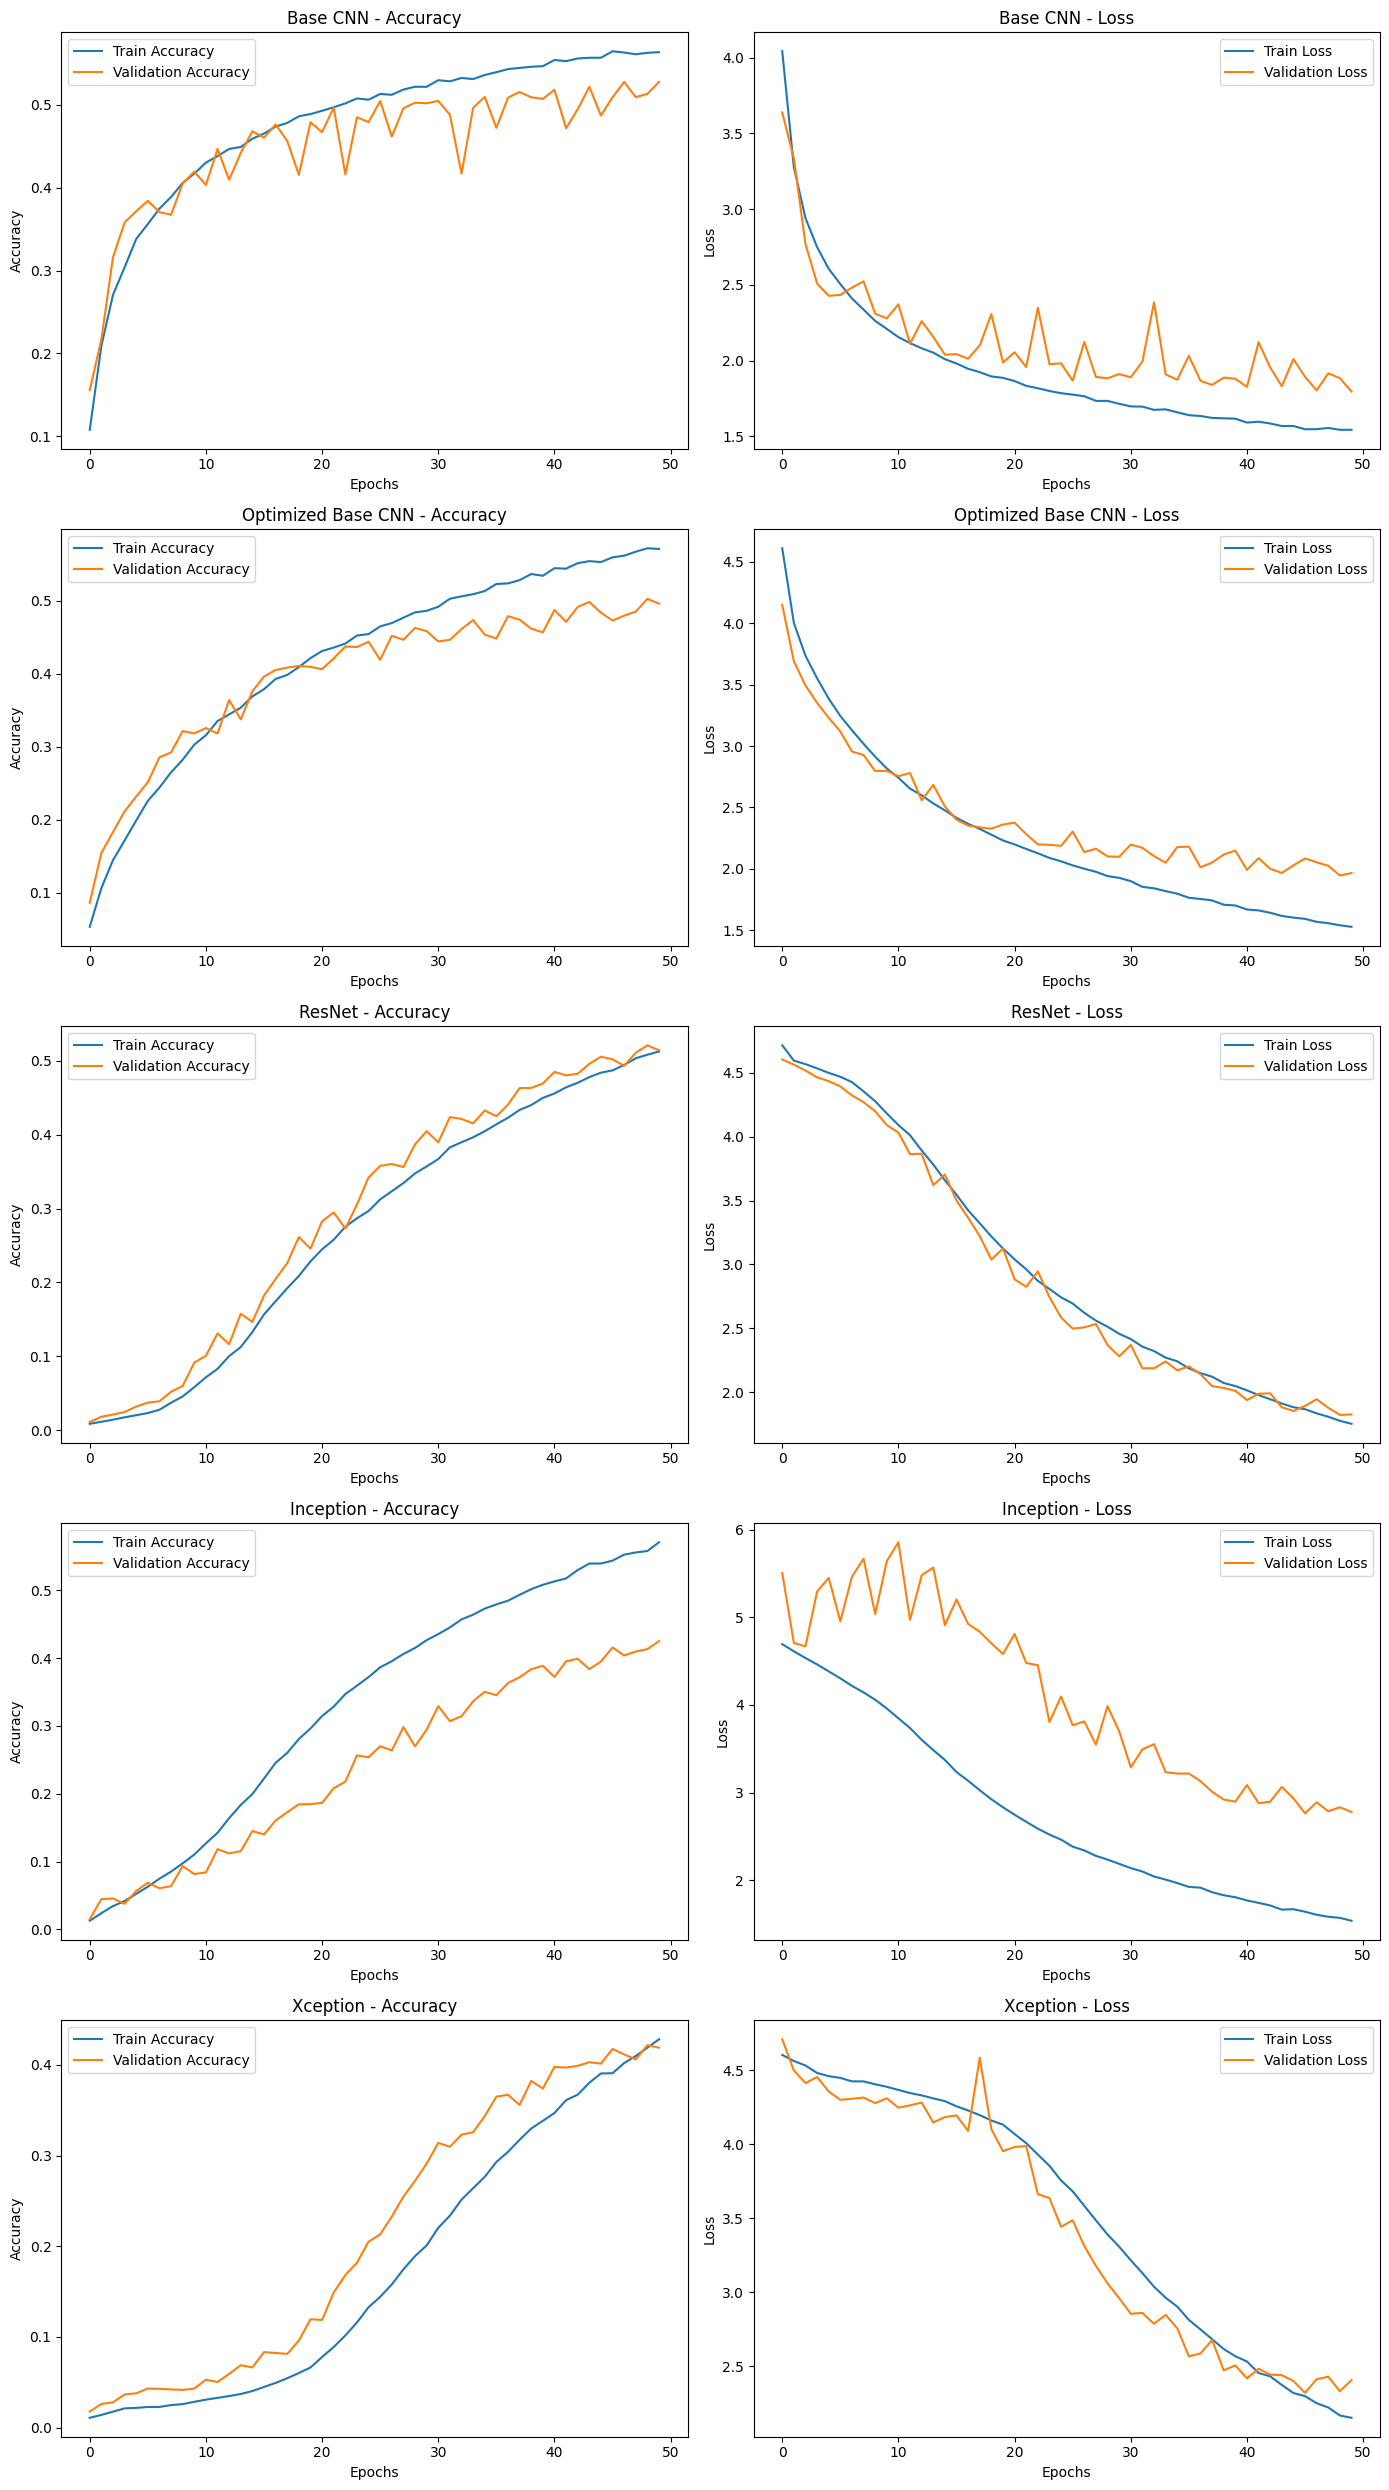

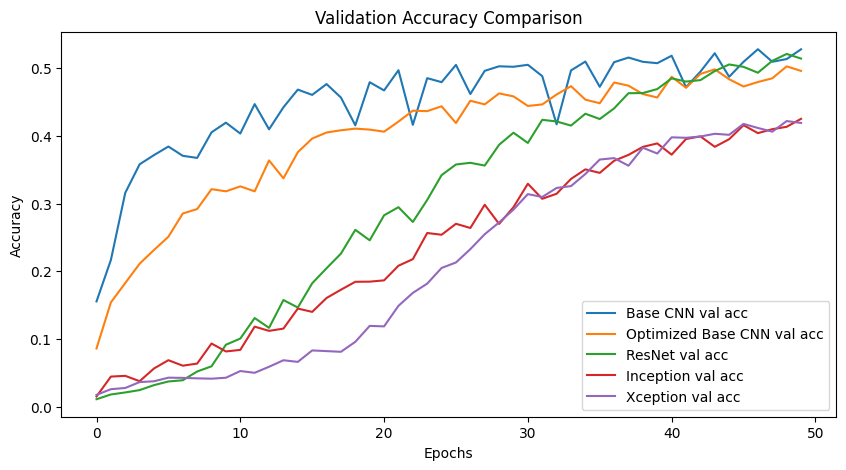

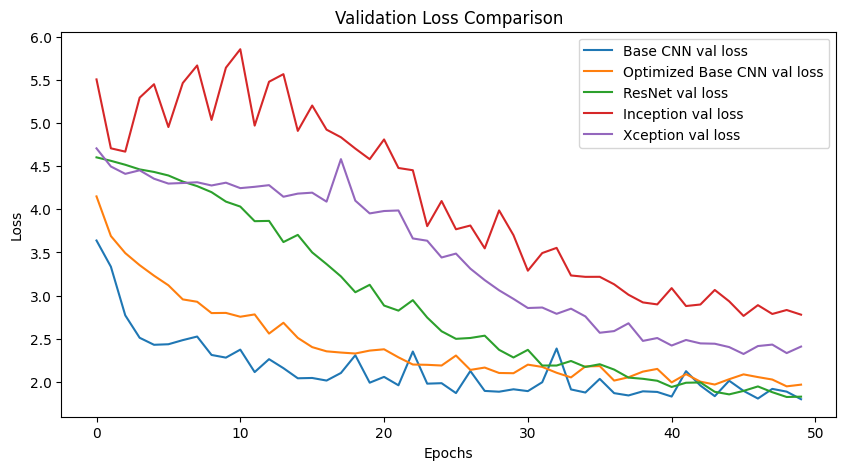

In [19]:
import matplotlib.pyplot as plt

def plot_results(histories, labels):
    num_models = len(histories)
    plt.figure(figsize=(14, num_models * 5))

    # Plot training & validation accuracy and loss for each model
    for i, (history, label) in enumerate(zip(histories, labels)):
        plt.subplot(num_models, 2, 2*i+1)
        plt.plot(history.history['accuracy'], label="Train Accuracy")
        plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
        plt.title(f"{label} - Accuracy")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.legend()

        plt.subplot(num_models, 2, 2*i+2)
        plt.plot(history.history['loss'], label="Train Loss")
        plt.plot(history.history['val_loss'], label="Validation Loss")
        plt.title(f"{label} - Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()

    plt.tight_layout()
    plt.show()

    # Plot validation accuracy comparison across models
    plt.figure(figsize=(10, 5))
    for history, label in zip(histories, labels):
        plt.plot(history.history['val_accuracy'], label=f"{label} val acc")
    plt.title("Validation Accuracy Comparison")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

    # Plot validation loss comparison across models
    plt.figure(figsize=(10, 5))
    for history, label in zip(histories, labels):
        plt.plot(history.history['val_loss'], label=f"{label} val loss")
    plt.title("Validation Loss Comparison")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

# Call function
plot_results(
    [base_history, optimized_base_history, resnet_history, inception_history, xception_history], 
    ["Base CNN", "Optimized Base CNN", "ResNet", "Inception", "Xception"]
)



#### Base CNN
The Base CNN model shows a steady increase in training accuracy, reaching approximately 55% by the end of the 50 epochs, while the validation accuracy plateaus around 50%. This gap between training and validation metrics indicates some small degree of overfitting, where the model performs better on the training data than on unseen validation data. 

Notably, the validation accuracy curve displays significant spikes throughout the training process, suggesting instability in the model's ability to generalize. The loss curves for this model show a consistent decrease over time, but the widening gap between training and validation loss further confirms the slight overfitting issue.

#### Optimized Base CNN
The Optimized Base CNN demonstrates performance characteristics similar to the original base model but with slightly improved generalization capabilities. The reduced gap between training and validation accuracy curves indicates that the optimization techniques have mitigated some of the overfitting issues. 

Both accuracy curves follow a more parallel trajectory than in the base model, suggesting more robust learning. The loss curves for this optimized version also show more consistent convergence patterns, with the validation loss tracking closer to the training loss compared to the base model.

#### ResNet
ResNet emerges as the architecture with the best generalization performance among all the models analyzed. The training and validation accuracy curves track remarkably closely throughout the entire training process, indicating excellent generalization capability. Both curves reach approximately 50% accuracy by the final epoch, with minimal divergence between them. 

Most impressively, the loss curves for ResNet align almost perfectly throughout training, further confirming the model's ability to learn patterns that generalize well to unseen data. While ResNet shows slightly slower initial learning compared to some other architectures, it demonstrates steadier and more reliable improvements over time.

#### Inception
The Inception architecture exhibits the most severe overfitting among all models evaluated. A substantial gap develops between the training accuracy (approximately 55%) and validation accuracy (around 40%) by the end of training. This significant divergence indicates that the model is memorizing the training data rather than learning generalizable patterns. 

The validation loss curve for Inception not only remains consistently higher than the training loss but also displays high volatility, particularly during early epochs. This volatility suggests that the model struggles to find stable representations that work well for the validation set.

#### Xception
Xception presents a unique and unusual learning pattern where the validation accuracy actually exceeds the training accuracy for a significant portion of the training process. This counterintuitive behavior could indicate that the model's architecture is particularly well-suited for the specific distribution of the validation dataset. Despite this unusual pattern, both loss curves converge well by the end of training. 

Xception demonstrates the slowest initial training progress among all models but catches up in later epochs, suggesting that its complex architecture may require more time to begin effectively learning the underlying patterns.

---

ResNet appears to be the most robust model with the best generalization performance. Inception suffers from the most overfitting, while Xception shows an interesting pattern where it seems to generalize better than it trains. The optimized base CNN shows improvements over the standard base CNN in terms of stability and reduced overfitting.

### 3.3.2 Comparing test and validation accuracies

In [27]:
def evaluate_model(model_name, X_test, y_test):
    model = tf.keras.models.load_model(f"{model_name}.h5")
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"{model_name}: Test Accuracy = {accuracy:.4f}, Test Loss = {loss:.4f}")

evaluate_model("base_cnn", X_test, y_test)
evaluate_model("optimized_base_cnn", X_test, y_test)
evaluate_model("resnet", X_test, y_test)
evaluate_model("inception", X_test, y_test)
evaluate_model("xception", X_test, y_test)

base_cnn: Test Accuracy = 0.5306, Test Loss = 1.7574
optimized_base_cnn: Test Accuracy = 0.5046, Test Loss = 1.9139


resnet: Test Accuracy = 0.5144, Test Loss = 1.7912


inception: Test Accuracy = 0.4330, Test Loss = 2.7122
xception: Test Accuracy = 0.4286, Test Loss = 2.3638


In [21]:
model_results = {
    "Base CNN": max(base_history.history["val_accuracy"]),
    "Optimized Base CNN": max(optimized_base_history.history["val_accuracy"]),
    "ResNet": max(resnet_history.history["val_accuracy"]),
    "Inception": max(inception_history.history["val_accuracy"]),
    "Xception": max(xception_history.history["val_accuracy"]),
}

sorted_results = sorted(model_results.items(), key=lambda x: x[1], reverse=True)
for model, acc in sorted_results:
    print(f"{model}: Best Validation Accuracy = {acc:.4f}")


Base CNN: Best Validation Accuracy = 0.5278
ResNet: Best Validation Accuracy = 0.5208
Optimized Base CNN: Best Validation Accuracy = 0.5025
Inception: Best Validation Accuracy = 0.4251
Xception: Best Validation Accuracy = 0.4218


### 3.3.3 Final results

                    Best Val Accuracy  Test Accuracy
base_cnn                       0.5278         0.5306
optimized_base_cnn             0.5025         0.5046
resnet                         0.5208         0.5144
inception                      0.4251         0.4330
xception                       0.4218         0.4286


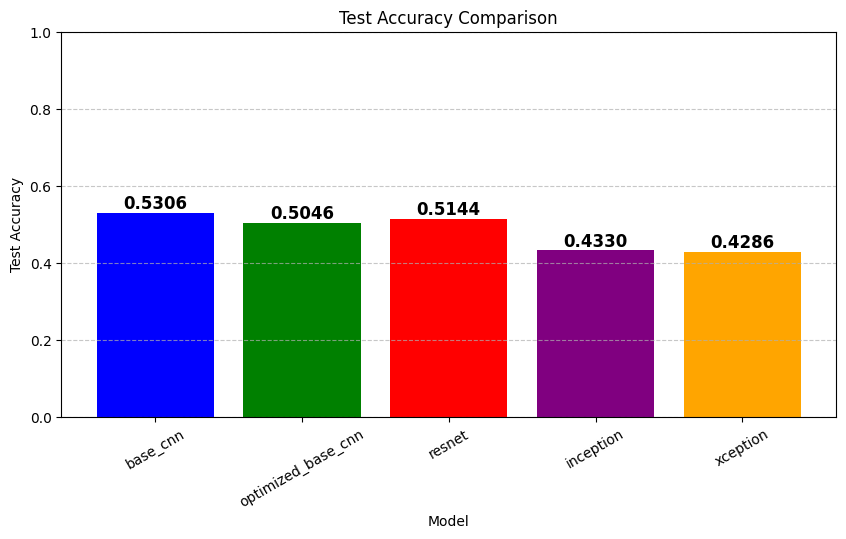

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

model_results = {
    "base_cnn": {
        "Best Val Accuracy": 0.5278,
        "Test Accuracy": 0.5306,
    },
    "optimized_base_cnn": {
        "Best Val Accuracy": 0.5025,
        "Test Accuracy": 0.5046,
    },
    "resnet": {
        "Best Val Accuracy": 0.5208,
        "Test Accuracy": 0.5144,
    },
    "inception": {
        "Best Val Accuracy": 0.4251,
        "Test Accuracy": 0.4330,
    },
    "xception": {
        "Best Val Accuracy": 0.4218,
        "Test Accuracy": 0.4286,
    },
}

# Convert results into a DataFrame for a structured table
df_results = pd.DataFrame(model_results).T  # Transpose for better readability

# Display the table
print(df_results)

# Plot bar graph for test accuracies
plt.figure(figsize=(10, 5))
plt.bar(df_results.index, df_results["Test Accuracy"], color=['blue', 'green', 'red', 'purple', 'orange'])

plt.title("Test Accuracy Comparison")
plt.xlabel("Model")
plt.ylabel("Test Accuracy")
plt.ylim(0, 1)  # Accuracy range 0-1
plt.xticks(rotation=30)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Display values on top of bars
for i, acc in enumerate(df_results["Test Accuracy"]):
    plt.text(i, acc + 0.01, f"{acc:.4f}", ha='center', fontsize=12, fontweight='bold')

plt.show()

The **Base CNN** achieves the highest validation accuracy (52.78%) and test accuracy (53.06%) with the lowest test loss (1.7574). While this model shows strong performance on these specific metrics, we should remember that it displayed significant fluctuations in its validation accuracy throughout training, as observed in the graphs.

**ResNet** performs as the second-best model with a validation accuracy of 52.08% and test accuracy of 51.44%. This aligns with our graphical observation of ResNet's excellent generalization capabilities, with training and validation curves tracking very closely together. Its test loss (1.7912) is comparable to the Base CNN, confirming its solid performance.

The **Optimized Base CNN** ranks third in peak metrics with a validation accuracy of 50.25% and test accuracy of 50.46%. However, as noted in the graphical analysis, this model demonstrated notably improved stability and more consistent convergence compared to the original Base CNN. While its peak performance is slightly lower, its greater stability suggests it might perform more reliably across different datasets or in production environments. The optimization efforts delivered valuable improvements in stability that single-point metrics don't fully capture.

**Inception** and **Xception** significantly underperform compared to the other models. Inception's validation accuracy of 42.51% and test accuracy of 43.30%, along with Xception's validation accuracy of 42.18% and test accuracy of 42.86%, are substantially lower than the simpler models. Their notably higher test losses (2.7122 and 2.3638 respectively) confirm the poor generalization observed in the graphs, particularly for Inception.